In [1]:
%matplotlib inline 

In [2]:
import os
import json
import re 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize

plt.rcParams['figure.figsize'] = [16, 9]

In [3]:
def CustomParser(data):
    return json.loads(data)


FOLDER = '../results/avulsos/'
regex = re.compile(r'.csv')
folders = set(os.listdir(FOLDER))
folders = filter(lambda i: regex.search(i), folders)
folders = [i for i in folders if regex.search(i)]

df = pd.DataFrame()
# Read csv file
for filename in folders:
    ddf = pd.read_csv(FOLDER + filename, sep=';', converters={'db_parameters': CustomParser, 'model_cfg': CustomParser})
    ddf[sorted(ddf['db_parameters'][0].keys())] = ddf['db_parameters'].apply(pd.Series)
    ddf[sorted(ddf['model_cfg'][0].keys())] = ddf['model_cfg'].apply(pd.Series)
    
    df = pd.concat([df, ddf])

In [4]:
df.shape

(434, 12)

In [5]:
FOLDER = '../results/'
folders = set(os.listdir(FOLDER))

regex = re.compile(r'.csv')
# use only one of the following lines, whichever you prefer
folders = filter(lambda i: not regex.search(i), folders)
folders = [i for i in folders if not regex.search(i)]

folders.remove('_sources')
folders.remove('avulsos')
folders

['results-20181105',
 'results-20181101',
 'results-old',
 'test',
 'results-20181121',
 'results-20181024']

In [6]:
result = {
    'acc': [],
    'f1': [],
    'db': [],
    'task': [],
    'model': [],
    'db_parameters': []
}

reports = pd.DataFrame()

report_id = 0
for root_folder in folders:
    for fold in os.listdir(FOLDER + root_folder):
        for run_id in os.listdir(FOLDER + root_folder + '/'+fold):
            current_folder = FOLDER + root_folder + '/' + fold + '/' + run_id

            metrics_file = current_folder + '/metrics-test.csv'
            config_file = current_folder + '/config.json'
            report_file = current_folder + '/report-train.csv'

            if not os.path.exists(metrics_file) or not os.path.exists(config_file):
                continue
                
            config_df = pd.read_json(config_file)
#             if config_df['dataset_cfg']['reader'] != "pypagai.preprocessing.dataset_babi.BaBIDataset":
#                 continue

            db = 'babi'
            task = config_df['dataset_cfg']['task']
            model = config_df['model_default_cfg']['model'].split('.')[-1]            
            
            if os.path.exists(report_file):
                report_df = pd.read_csv(report_file)
                report_df = report_df.reset_index()
                report_df['dataset'] = db
                report_df['task'] = task
                report_df['model'] = model
                report_df['id'] = report_id
                reports = pd.concat([reports,report_df])
                report_id += 1

            metrics_df = pd.read_csv(metrics_file)
            acc = metrics_df['accuracy'][0]
            f1 = metrics_df['f1_micro'][0]

            result['f1'].append(f1)
            result['db'].append(db)
            result['acc'].append(acc)
            result['task'].append(task)
            result['model'].append(model)
            result['db_parameters'].append(config_file)

new_results = pd.DataFrame(result)
df = pd.concat([df, new_results])

model,ConvInputsRN,ConvLSTM,ConvQueryRN,ConvRN,ConvStoryRN,DeepN2NMemory,EmbedLSTM,EncoderModel,N2NMemory,RN,RNNModel,RNNoLSTM,SimpleLSTM
task,,,,,,,,,,,,,
1,0.826,0.859,0.763,0.941,0.911,0.963,0.979,0.349,0.953,0.819,1.000,0.813,0.504
2,0.477,0.442,0.489,NaN,0.450,0.325,0.445,0.370,0.281,0.488,0.439,NaN,0.190
3,0.380,NaN,0.339,NaN,0.296,0.251,0.534,0.310,0.242,0.417,0.405,NaN,0.207
4,NaN,NaN,1.000,NaN,NaN,1.000,1.000,0.572,1.000,1.000,1.000,NaN,0.279
5,0.991,NaN,0.981,NaN,0.992,0.826,0.990,0.313,0.869,0.995,0.990,NaN,0.344
6,0.776,NaN,0.904,NaN,0.889,0.972,0.679,0.527,0.995,0.883,0.819,NaN,0.636
7,0.836,NaN,0.864,NaN,0.859,0.904,0.811,0.764,0.879,0.895,0.998,NaN,0.693
8,0.821,NaN,0.832,NaN,0.808,0.802,0.769,0.740,0.804,0.827,0.997,NaN,0.539
9,NaN,NaN,0.855,NaN,NaN,0.962,0.626,0.585,0.959,0.841,1.000,0.827,0.655


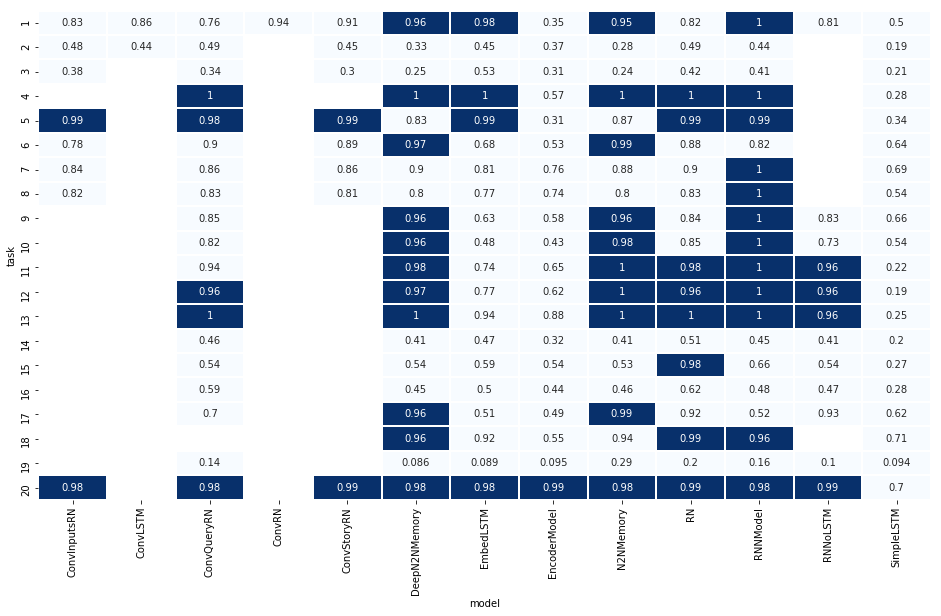

In [7]:
# Show best result of each model for each babi task
# model_list = ['ConvInputsRN','ConvQueryRN','ConvRN','ConvStoryRN','EmbedLSTM','EncoderModel','RNNModel','RNNoLSTM','SimpleLSTM']

ddf = df[df['db'] == 'babi']
# ddf = ddf[~(ddf['model'].isin(model_list))]
ddf = ddf.groupby(['db', 'model', 'task'])
ddf = ddf.max()
ddf = ddf.reset_index()
pivot = ddf[['model', 'acc', 'task']].pivot('task', 'model')
pivot = pivot['acc']

plt.figure(figsize = (16,9))
sns.heatmap(pivot, cmap="Blues", linewidths=1, annot=True, cbar=False, vmin=0.949, vmax=0.95)
pivot

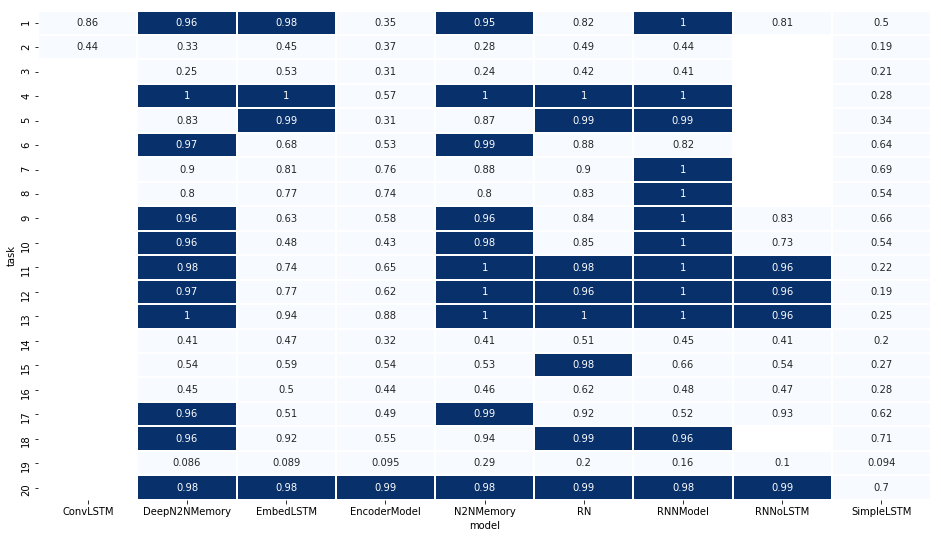

In [9]:
# Show best result of each model for each babi task
model_list = ['ConvInputsRN','ConvQueryRN','ConvRN','ConvStoryRN',]

ddf = df[df['db'] == 'babi']
ddf = ddf[~(ddf['model'].isin(model_list))]
ddf = ddf.groupby(['db', 'model', 'task'])
ddf = ddf.max()
ddf = ddf.reset_index()
pivot = ddf[['model', 'acc', 'task']].pivot('task', 'model')
pivot = pivot['acc']

plt.figure(figsize = (16,9))
sns.heatmap(pivot, cmap="Blues", linewidths=1, annot=True, cbar=False, vmin=0.949, vmax=0.95)

# Epoch evolution

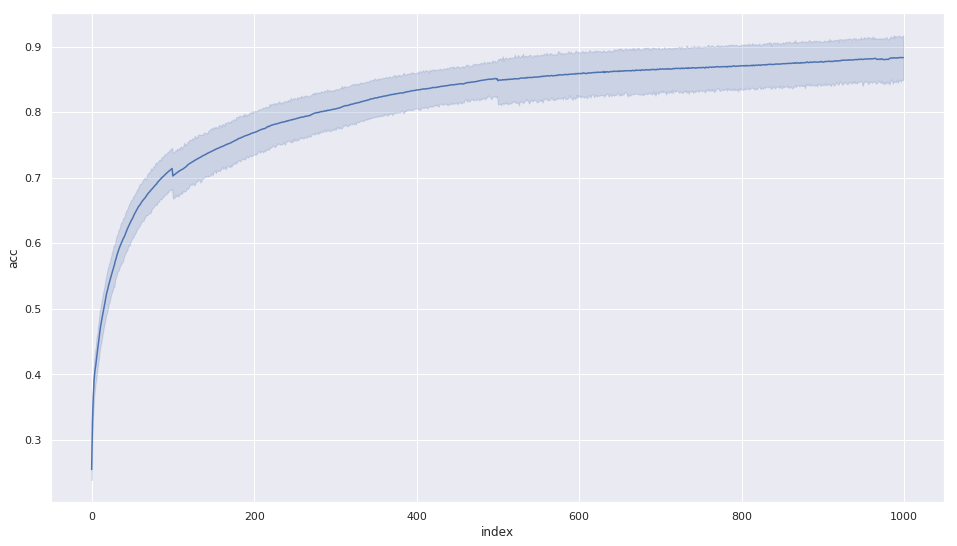

In [10]:
import seaborn as sns
sns.set(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="index", y="acc", data=reports)

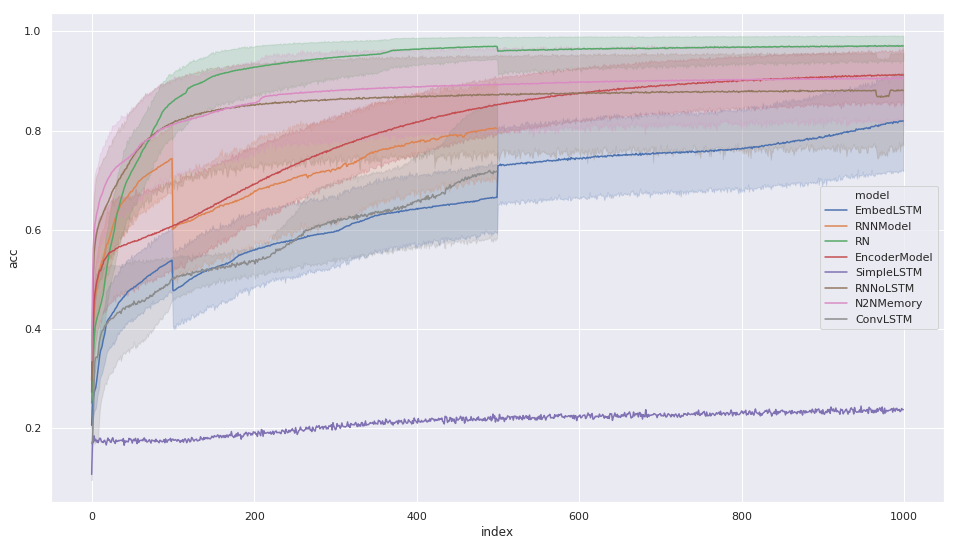

In [11]:
sns.lineplot(x="index", y="acc", hue='model', data=reports[~reports['model'].isin(model_list)])

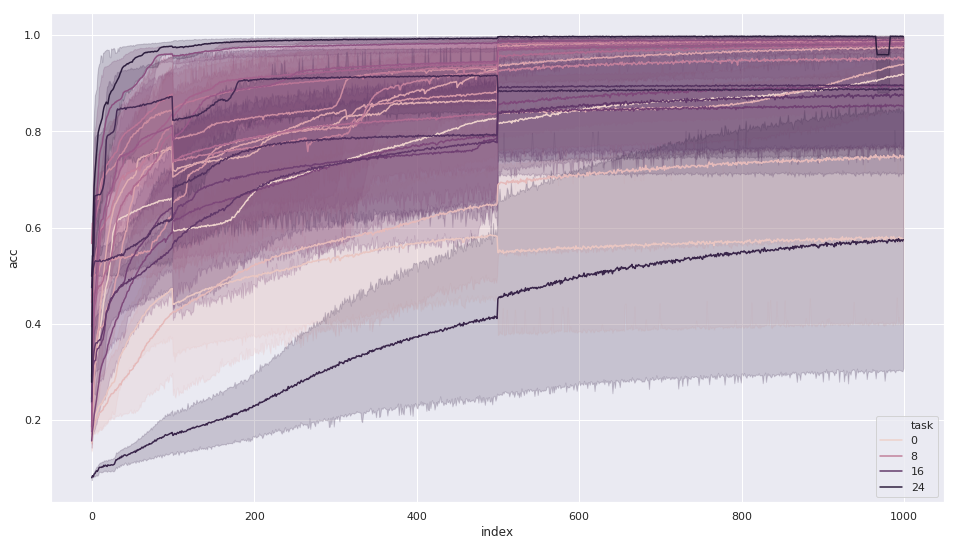

In [12]:
sns.lineplot(x="index", y="acc", hue='task', data=reports[~reports['model'].isin(model_list)])

In [13]:
reports['task'] = reports['task'].astype(int)
reports['task'].unique()

array([ 6, 10,  9, 18,  1, 15, 20,  3, 11, 17, 13,  2,  8,  7, 16, 19,  5,
        4, 14, 12])